In [27]:
import pandas as pd
import re, string, unicodedata
import nltk
import xgboost as xgb
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [28]:
#Loading the data
df_data = pd.read_csv('mbti_1.csv')

# Removed |||
df_data.posts = df_data.posts.replace(r'[|||]', r' ', regex=True)
df_data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired. That's another silly misconce...


      posts
type       
ENFJ    190
ENFP    675
ENTJ    231
ENTP    685
ESFJ     42
ESFP     48
ESTJ     39
ESTP     89
INFJ   1470
INFP   1832
INTJ   1091
INTP   1304
ISFJ    166
ISFP    271
ISTJ    205
ISTP    337


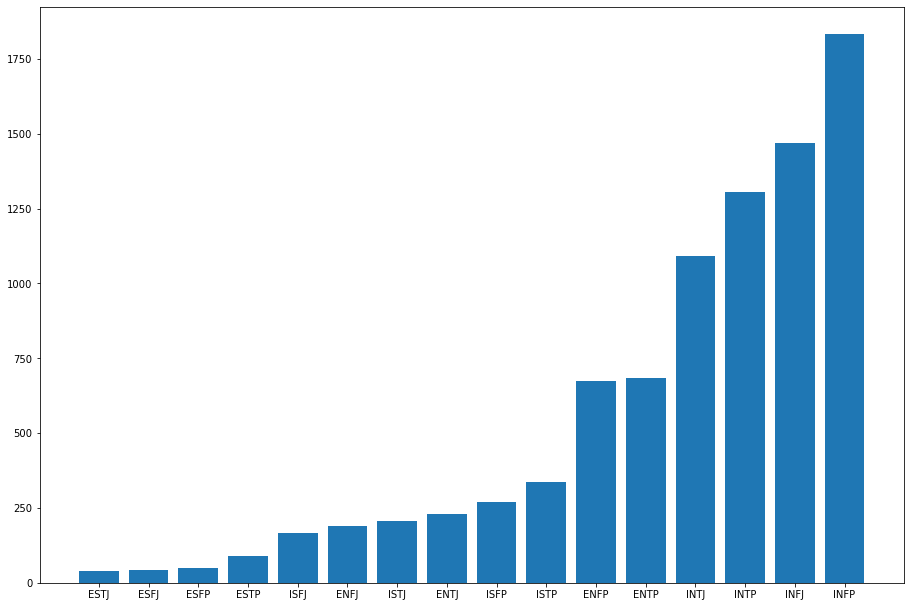

In [29]:
#Data is not balanced
def count_class(DataFrame,count = False ,plot = False):
    # considering 1st Column is for classes 
    Classes = list(df_data[df_data.columns[0]].unique())
    #print(Classes)
    if plot or count:
        count_type = df_data.groupby('type').count()
    if count : print(count_type)
    if plot:
        fig = plt.figure()
        ax = fig.add_axes([0,0,2,2])
        count_type_temp = count_type.sort_values('posts')
        ax.bar(count_type_temp.index,count_type_temp['posts'])
        plt.show()
    return Classes

classes = count_class(df_data,True,True)

In [30]:
#Diving the 16 MBTI type to only 4
df_data['is_E'] = df_data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df_data['is_S'] = df_data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df_data['is_T'] = df_data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_data['is_J'] = df_data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df_data

,type,posts,is_E,is_S,is_T,is_J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,ENFP,'So...if this thread already exists someplace ...,1,0,0,0
8672,INTP,'So many questions when i do these things. I ...,0,0,1,0
8673,INFP,'I am very conflicted right now when it comes ...,0,0,0,0


In [31]:
#dropping the type column
df_data = df_data.drop(['type'], axis=1)
df_data

,posts,is_E,is_S,is_T,is_J
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,'So...if this thread already exists someplace ...,1,0,0,0
8672,'So many questions when i do these things. I ...,0,0,1,0
8673,'I am very conflicted right now when it comes ...,0,0,0,0


In [32]:
#Separating the data according to I/E , N/S, F/T AND P/J. All of them has the post column
df_data_IE = df_data.drop(['is_S', 'is_T', 'is_J'], axis=1)
df_data_NS = df_data.drop(['is_E', 'is_T', 'is_J'], axis=1)
df_data_FT = df_data.drop(['is_S', 'is_E', 'is_J'], axis=1)
df_data_PJ = df_data.drop(['is_S', 'is_T', 'is_E'], axis=1)

df_data_IE.head()

,posts,is_E
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0
1,'I'm finding the lack of me in these posts ver...,1
2,'Good one _____ https://www.youtube.com/wat...,0
3,"'Dear INTP, I enjoyed our conversation the o...",0
4,'You're fired. That's another silly misconce...,1


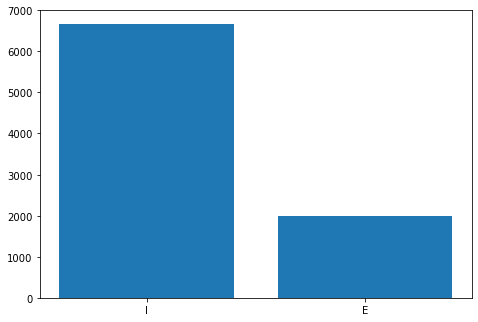

In [33]:
#After spliiting the personaliy type showing the data is still unbalanced for I/E and N/S
I, E = df_data_IE['is_E'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['I', 'E']
students = [I, E]
ax.bar(langs,students)
plt.show()

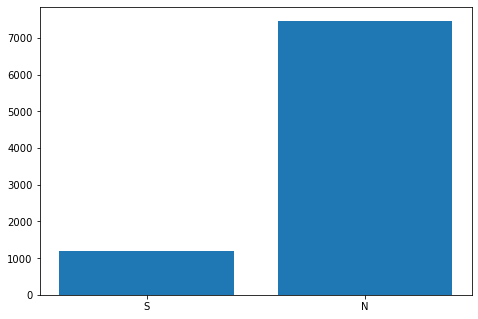

In [34]:
N, S = df_data_NS['is_S'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['S', 'N']
students = [S, N]
ax.bar(langs,students)
plt.show()

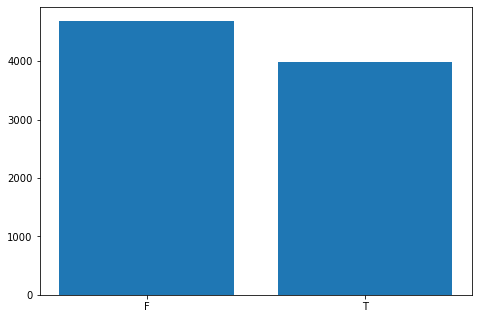

In [35]:
F, T = df_data_FT['is_T'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['F', 'T']
students = [F, T]
ax.bar(langs,students)
plt.show()

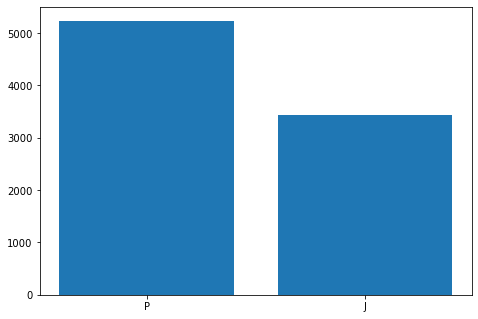

In [36]:
P, J = df_data_PJ['is_J'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['P', 'J']
students = [P, J]
ax.bar(langs,students)
plt.show()

In [37]:
# Over Sampling then undersampling
# define resampling
#over = RandomOverSampler(sampling_strategy=0.1)
#under = RandomUnderSampler(sampling_strategy=0.5)
# define pipeline
#pipeline = Pipeline(steps=[('o', over), ('u', under)])

#pipeline.fit(df_data_IE)

In [38]:
#Separating into training, validation and Testing data 60, 20, 20 - 5205, 1735 and 1735
train_IE, validate_IE, test_IE = np.split(df_data_IE.sample(frac=1, random_state=42), [int(.6*len(df_data_IE)), int(.8*len(df_data_IE))])
train_NS, validate_NS, test_NS = np.split(df_data_NS.sample(frac=1, random_state=42), [int(.6*len(df_data_NS)), int(.8*len(df_data_NS))])
train_FT, validate_FT, test_FT = np.split(df_data_FT.sample(frac=1, random_state=42), [int(.6*len(df_data_FT)), int(.8*len(df_data_FT))])
train_PJ, validate_PJ, test_PJ = np.split(df_data_PJ.sample(frac=1, random_state=42), [int(.6*len(df_data_PJ)), int(.8*len(df_data_PJ))])

validate_IE   # to see the df if correct data is transfered

#Transfering to dataframe
#train_IE = pd.DataFrame(train_IE)
#validate_IE = pd.DataFrame(validate_IE)
#test_IE = pd.DataFrame(test_IE)

,posts,is_E
7201,"'Judson Joist, OMG! You deserve the highest of...",0
1812,'-Dreams are you experiencing the multiverse ...,0
5894,'Likes: 1. Extremely intelligent and well edu...,0
6510,"'Ooh, ENTJ Celestia is actually an interesting...",0
4912,Don't know much about this forum either. Lol I...,0
...,...,...
7937,"'Yay, an ISFP! Welcome! As someone with artis...",0
5016,"I just don't care anymore, I feel nothing. Per...",1
8436,"'I only know one other, my son. Is our type re...",0
987,'I don't think sense of vision is necessarily ...,0


In [39]:
#Split the data to X and Y i.e. posts and labels
#For IE labels
X_train_IE = pd.DataFrame(train_IE['posts'])
Y_train_IE = pd.DataFrame(train_IE['is_E'])
X_validate_IE = pd.DataFrame(validate_IE['posts'])
Y_validate_IE = pd.DataFrame(validate_IE['is_E'])
X_test_IE = pd.DataFrame(test_IE['posts'])
Y_test_IE = pd.DataFrame(test_IE['is_E'])

#For IE labels
X_train_NS = pd.DataFrame(train_NS['posts'])
Y_train_NS = pd.DataFrame(train_NS['is_S'])
X_validate_NS = pd.DataFrame(validate_NS['posts'])
Y_validate_NS = pd.DataFrame(validate_NS['is_S'])
X_test_NS = pd.DataFrame(test_NS['posts'])
Y_test_NS = pd.DataFrame(test_NS['is_S'])

#For IE labels
X_train_FT = pd.DataFrame(train_FT['posts'])
Y_train_FT = pd.DataFrame(train_FT['is_T'])
X_validate_FT = pd.DataFrame(validate_FT['posts'])
Y_validate_FT = pd.DataFrame(validate_FT['is_T'])
X_test_FT = pd.DataFrame(test_FT['posts'])
Y_test_FT = pd.DataFrame(test_FT['is_T'])

#For IE labels
X_train_PJ = pd.DataFrame(train_PJ['posts'])
Y_train_PJ = pd.DataFrame(train_PJ['is_J'])
X_validate_PJ = pd.DataFrame(validate_PJ['posts'])
Y_validate_PJ = pd.DataFrame(validate_PJ['is_J'])
X_test_PJ = pd.DataFrame(test_PJ['posts'])
Y_test_PJ = pd.DataFrame(test_PJ['is_J'])
display(Y_train_IE.iloc[1])
X_train_PJ.head()

is_E    0
Name: 2166, dtype: int64

,posts
2802,'This. When I lie it's to avoid an unreasonabl...
2166,'I said zero flexibility and little time for d...
1919,'This has to be written with bias or something...
360,'HAuhuHAuh You might be right Muhicz. I'm just...
1115,'Her parents are kind of the go to college = g...


In [40]:
#Cleaning the data Round 1
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers, remove URL, remove @, '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

X_train_IE_clean = pd.DataFrame(df_data.posts.apply(round1))
X_train_IE_clean

,posts
0,enfp and intj moments sportscenter no...
1,im finding the lack of me in these posts very ...
2,good one of course to which i say i kno...
3,dear intp i enjoyed our conversation the oth...
4,youre fired thats another silly misconceptio...
...,...
8670,ixfp just because i always think of cats as...
8671,soif this thread already exists someplace else...
8672,so many questions when i do these things i wo...
8673,i am very conflicted right now when it comes t...


In [41]:
# Tokenization - this is taken from SpaCy

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = LancasterStemmer()

def tokenize(s):
    tokens = re_tok.sub(r' \1 ', s).split()
    return tokens

In [42]:
#Remove stopword and also added the MBTI types to it
stop = set(stopwords.words('english'))
stop.update(['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ISTP','ISFP','ENTJ','ISTJ','ENFJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [43]:
from tqdm import tqdm

embeddings_index_fastText = {}
f = open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index_fastText[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_fastText))

1999996it [01:50, 18127.63it/s]

Found 1999996 word vectors.


In [44]:
def sent2vec(s, embeddings_index):
    words = str(s)
    words = tokenize(words)
    words = remove_stopwords(words)
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [45]:
gc.collect()

# Create sentence vectors using the above function for training and validation set - this will convert the full sentence 
#into a vector and as the fastText has 300 d thats why the sent vec also has 300d - ONly done for is_E for now

xtrain_IE_fastText = [sent2vec(x, embeddings_index_fastText) for x in X_train_IE['posts']]
xvalid_IE_fastText = [sent2vec(x, embeddings_index_fastText) for x in X_validate_IE['posts']]

xtrain_IE_fastText = np.array(xtrain_IE_fastText)
xvalid_IE_fastText = np.array(xvalid_IE_fastText)

print("xtrain_IE_fastText.shape = ", xtrain_IE_fastText.shape)
print("xvalid_IE_fastText.shape = ", xvalid_IE_fastText.shape)
 
# Generate Word vectors of test data
xtest_IE_fastText = [sent2vec(x, embeddings_index_fastText) for x in X_test_IE['posts']]
xtest_IE_fastText = np.array(xtest_IE_fastText)

print("xtest_IE_fastText.shape = ", xtest_IE_fastText.shape)

xtrain_IE_fastText.shape =  (5205, 300)
xvalid_IE_fastText.shape =  (1735, 300)
xtest_IE_fastText.shape =  (1735, 300)


,posts,is_E,is_S,is_T,is_J
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,'You're fired. That's another silly misconce...,1,0,1,1


In [46]:
# SVM Done for is_E class
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='log', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_fastText, Y_train_IE[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_fastText, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_fastText, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_E
CV score for class is_E is 0.751637242692843
Validation score for class is_E is 0.723342939481268


In [47]:
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)
    
    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_fastText, Y_train_IE[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_fastText, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_fastText, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_E
CV score for class is_E is 0.6983967684209424
Validation score for class is_E is 0.6403458213256484


In [58]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['verbosity'] = 0
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    return model

In [59]:
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB(xtrain_IE_fastText, Y_train_IE[class_name], xvalid_IE_fastText, Y_validate_IE[class_name])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_IE_fastText), ntree_limit = model.best_ntree_limit)
    gc.collect()

fit is_E
[0]	train-auc:0.72798	valid-auc:0.59735
[1]	train-auc:0.78498	valid-auc:0.61661
[2]	train-auc:0.81793	valid-auc:0.64172
[3]	train-auc:0.84832	valid-auc:0.64409
[4]	train-auc:0.86921	valid-auc:0.65237
[5]	train-auc:0.88075	valid-auc:0.65239
[6]	train-auc:0.89653	valid-auc:0.64884
[7]	train-auc:0.90494	valid-auc:0.65758
[8]	train-auc:0.91157	valid-auc:0.66731
[9]	train-auc:0.91854	valid-auc:0.66836
[10]	train-auc:0.92394	valid-auc:0.67090
[11]	train-auc:0.93032	valid-auc:0.67101
[12]	train-auc:0.93605	valid-auc:0.67177
[13]	train-auc:0.94135	valid-auc:0.67612
[14]	train-auc:0.94485	valid-auc:0.67889
[15]	train-auc:0.94877	valid-auc:0.68177
[16]	train-auc:0.95440	valid-auc:0.68519
[17]	train-auc:0.95738	valid-auc:0.68640
[18]	train-auc:0.95917	valid-auc:0.69113
[19]	train-auc:0.96260	valid-auc:0.69164
[20]	train-auc:0.96418	valid-auc:0.69161
[21]	train-auc:0.96807	valid-auc:0.69360
[22]	train-auc:0.97153	valid-auc:0.69623
[23]	train-auc:0.97344	valid-auc:0.70013
[24]	train-auc:0.

In [60]:
gc.collect()

# Create sentence vectors using the above function for training and validation set - this will convert the full sentence 
#into a vector and as the fastText has 300 d thats why the sent vec also has 300d - ONly done for is_E for now

xtrain_FT_fastText = [sent2vec(x, embeddings_index_fastText) for x in X_train_FT['posts']]
xvalid_FT_fastText = [sent2vec(x, embeddings_index_fastText) for x in X_validate_FT['posts']]

xtrain_FT_fastText = np.array(xtrain_FT_fastText)
xvalid_FT_fastText = np.array(xvalid_FT_fastText)

print("xtrain_FT_fastText.shape = ", xtrain_FT_fastText.shape)
print("xvalid_FT_fastText.shape = ", xvalid_FT_fastText.shape)
 
# Generate Word vectors of test data
xtest_FT_fastText = [sent2vec(x, embeddings_index_fastText) for x in X_test_FT['posts']]
xtest_FT_fastText = np.array(xtest_FT_fastText)

print("xtest_IE_fastText.shape = ", xtest_FT_fastText.shape)

xtrain_FT_fastText.shape =  (5205, 300)
xvalid_FT_fastText.shape =  (1735, 300)
xtest_IE_fastText.shape =  (1735, 300)


In [62]:
# SVM Done for is_T class
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='log', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_fastText, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_fastText, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_fastText, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_T
CV score for class is_T is 0.8466054342338726
Validation score for class is_T is 0.7463976945244957


In [61]:
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)
    
    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_fastText, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_fastText, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_fastText, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_T
CV score for class is_T is 0.7716591849208435
Validation score for class is_T is 0.7268011527377521


In [63]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['verbosity'] = 0
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    return model

In [64]:
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB(xtrain_FT_fastText, Y_train_FT[class_name], xvalid_FT_fastText, Y_validate_FT[class_name])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_FT_fastText), ntree_limit = model.best_ntree_limit)
    gc.collect()

fit is_T
[0]	train-auc:0.81484	valid-auc:0.73522
[1]	train-auc:0.86281	valid-auc:0.76294
[2]	train-auc:0.88699	valid-auc:0.77790
[3]	train-auc:0.89994	valid-auc:0.78472
[4]	train-auc:0.91247	valid-auc:0.80107
[5]	train-auc:0.92154	valid-auc:0.80949
[6]	train-auc:0.92782	valid-auc:0.81638
[7]	train-auc:0.93507	valid-auc:0.81990
[8]	train-auc:0.93913	valid-auc:0.82326
[9]	train-auc:0.94328	valid-auc:0.82710
[10]	train-auc:0.94618	valid-auc:0.82901
[11]	train-auc:0.94865	valid-auc:0.83040
[12]	train-auc:0.95147	valid-auc:0.83260
[13]	train-auc:0.95328	valid-auc:0.83366
[14]	train-auc:0.95471	valid-auc:0.83441
[15]	train-auc:0.95710	valid-auc:0.83603
[16]	train-auc:0.95974	valid-auc:0.83718
[17]	train-auc:0.96226	valid-auc:0.83948
[18]	train-auc:0.96424	valid-auc:0.83966
[19]	train-auc:0.96549	valid-auc:0.84066
[20]	train-auc:0.96804	valid-auc:0.84156
[21]	train-auc:0.97009	valid-auc:0.84218
[22]	train-auc:0.97210	valid-auc:0.84391
[23]	train-auc:0.97376	valid-auc:0.84364
[24]	train-auc:0.